In [2]:
import logging
import os
import sys
from itertools import product
from pathlib import Path
from typing import Dict, List, Optional, Union

import IPython
import matplotlib
from seaborn._statistics import LetterValues
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import textalloc as ta
from tqdm import tqdm

NOTEBOOK_PATH: Path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
PROJECT_DIR: Path = NOTEBOOK_PATH.parent.parent
sys.path.append(str(PROJECT_DIR))
import src.utils.custom_log as custom_log
from src._StandardNames import StandardNames
from src.load.LoadForClassification import RENAMER, LoadForClassification
from src.utils.PathChecker import PathChecker
from src.utils.set_rcparams import set_rcparams
import src.utils.json_util as json_util

os.chdir(PROJECT_DIR)
set_rcparams()

LOG: logging.Logger = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Log start, project directory is %s (exist: %s)", PROJECT_DIR, PROJECT_DIR.is_dir())

CHECK: PathChecker = PathChecker()
STR: StandardNames = StandardNames()

FIG_DIR: Path = CHECK.check_directory(PROJECT_DIR / "reports" / "figures", exit=False)
FIG_DIR /= NOTEBOOK_PATH.stem
FIG_DIR.mkdir(parents=True, exist_ok=True)
LOG.info("Figure directory is %s (exist: %s)", FIG_DIR, FIG_DIR.is_dir())

DEV_DATA_DIR: Path = CHECK.check_directory(PROJECT_DIR / "data" / "doe" / "doe_sobol_20240705_194200", exit=False)
DEV_INJ_FPATH: Path = CHECK.check_file(DEV_DATA_DIR / "injury_criteria.parquet", exit=False)
DEV_DOE_FPATH: Path = CHECK.check_file(DEV_DATA_DIR / "doe_combined.parquet", exit=False)
DEV_DROP_PATH: Path = CHECK.check_file(DEV_DATA_DIR / "dropped_ids.json", exit=False)

TEST_DATA_DIR: Path = CHECK.check_directory(PROJECT_DIR / "data" / "doe" / "doe_sobol_test_20240829_135200", exit=False)
TEST_INJ_FPATH: Path = CHECK.check_file(TEST_DATA_DIR / "injury_criteria.parquet", exit=False)
TEST_DOE_FPATH: Path = CHECK.check_file(TEST_DATA_DIR / "doe.parquet", exit=False)
TEST_DROP_PATH: Path = CHECK.check_file(TEST_DATA_DIR / "dropped_ids.json", exit=False)

TRANS_DATA_DIR: Path = CHECK.check_directory(PROJECT_DIR / "data" / "doe" / "virthuman", exit=False)
TRANS_INJ_FPATH: Path = CHECK.check_file(TRANS_DATA_DIR / "injury_criteria.parquet", exit=False)
TRANS_DOE_FPATH: Path = CHECK.check_file(TRANS_DATA_DIR / "doe.parquet", exit=False)
TRANS_DROP_PATH: Path = CHECK.check_file(TRANS_DATA_DIR / "dropped_ids.json", exit=False)

ALT_DEV_DATA_DIR: Path = CHECK.check_directory(PROJECT_DIR / "data" / "doe" / "doe_big_grid_20230922_154140", exit=False)
ALT_DEV_INJ_FPATH: Path = CHECK.check_file(ALT_DEV_DATA_DIR / "injury_criteria.parquet", exit=False)
ALT_DEV_DOE_FPATH: Path = CHECK.check_file(ALT_DEV_DATA_DIR / "doe.parquet", exit=False)
ALT_DEV_DROP_PATH: Path = CHECK.check_file(ALT_DEV_DATA_DIR / "dropped_ids.json", exit=False)
ALT_DEV_PARSER_PATH:Path = CHECK.check_file(ALT_DEV_DATA_DIR / "sim_id_2_id.parquet", exit=False)

2025-01-04 12:57:28,418     INFO  MainProcess  MainThread Log start, project directory is /root/py_projects/aihiii (exist: True)
2025-01-04 12:57:28,419     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/reports/figures' exists
2025-01-04 12:57:28,421     INFO  MainProcess  MainThread Figure directory is /root/py_projects/aihiii/reports/figures/dev_set_vs_test_set_data_distribution (exist: True)
2025-01-04 12:57:28,421     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200' exists
2025-01-04 12:57:28,425     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists
2025-01-04 12:57:28,426     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/doe_combined.parquet' exists
2025-01-04 12:57:28,427     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/dropped_ids.

In [3]:
INJURIES: List[str] = [
    "Head_HIC15",
    "Head_a3ms",
    "Neck_My_Extension",
    "Neck_Fz_Max_Tension",
    "Neck_Fx_Shear_Max",
    "Chest_a3ms",
    "Chest_Deflection",
    "Chest_VC",
    "Femur_Fz_Max_Compression",
]
INJ_NAMES: Dict[str, str] = {
    "Head_HIC15": "Head HIC$_{15}$",
    "Head_a3ms": "Head HAC$_3$",
    "Neck_My_Extension": "Neck NEC",
    "Neck_Fz_Max_Tension": "Neck NTC",
    "Neck_Fx_Shear_Max": "Neck NSC",
    "Chest_a3ms": "Chest CAC$_3$",
    "Chest_Deflection": "Chest CDC",
    "Chest_VC": "Chest CVC",
    "Femur_Fz_Max_Compression": "Femur FCC",
}
WIDTH = 448.13095 / 72 -0.2

In [4]:
def save_fig(fig: matplotlib.figure.Figure, f_name: str, close=True) -> None:
    f_path = FIG_DIR / f_name
    fig.savefig(f_path.with_suffix(".pdf"), transparent=False)
    LOG.info("Saved figure to %s", f_path)
    if close:
        plt.close(fig)

In [5]:
def get_drops(db_path: Path, perc: int = 5) -> List[int]:
    json_path = DEV_DROP_PATH if db_path == DEV_INJ_FPATH else TEST_DROP_PATH
    return sorted(set(json_util.load(f_path=json_path)[str(perc)]))


get_drops(DEV_INJ_FPATH)

[68,
 102,
 600,
 1388,
 3673,
 3687,
 3848,
 4720,
 5100,
 5665,
 5733,
 5739,
 6320,
 6802,
 7533]

In [6]:
def get_dev_set_para_ranges(db_path: Path, perc: int = 5) -> pd.DataFrame:
    db_min = (
        pl.scan_parquet(db_path)
        .filter(pl.col(STR.perc) == perc)
        .select(pl.exclude([STR.perc, STR.id, STR.sim_id]))
        .select([pl.all().min()])
        .with_columns(pl.lit("MIN").alias("What"))
    )
    db_max = (
        pl.scan_parquet(db_path)
        .filter(pl.col(STR.perc) == perc)
        .select(pl.exclude([STR.perc, STR.id, STR.sim_id]))
        .select([pl.all().max()])
        .with_columns(pl.lit("MAX").alias("What"))
    )
    db = pl.concat([db_min, db_max]).collect().to_pandas().set_index("What")

    return db

get_dev_set_para_ranges(DEV_DOE_FPATH)

,PAB_M_Scal,PAB_Vent_T,Pulse_Angle,Pulse_X_Scale,SLL
What,,,,,
MIN,0.900000,0.070000,-10.000000,0.800000,2140.000000
MAX,1.099976,0.129993,9.997559,1.199951,2539.951172


In [7]:
def get_inj_data(inj_fpath: Path, val: str, perc: int = 5, ids: Optional[List[int]] = None) -> pd.Series:
    drops = get_drops(inj_fpath, perc)
    if ids is None:
        db = (
            pl.scan_parquet(inj_fpath)
            .filter(pl.col(STR.perc) == perc)
            .filter(~pl.col(STR.id).is_in(drops))
            .select([val, STR.id])
            .collect()
            .to_pandas()
            .set_index(STR.id)[val]
        )
    else:
        db = (
            pl.scan_parquet(inj_fpath)
            .filter(pl.col(STR.perc) == perc)
            .filter(pl.col(STR.id).is_in(ids))
            .filter(~pl.col(STR.id).is_in(drops))
            .select([val, STR.id])
            .collect()
            .to_pandas()
            .set_index(STR.id)[val]
        )
    return db

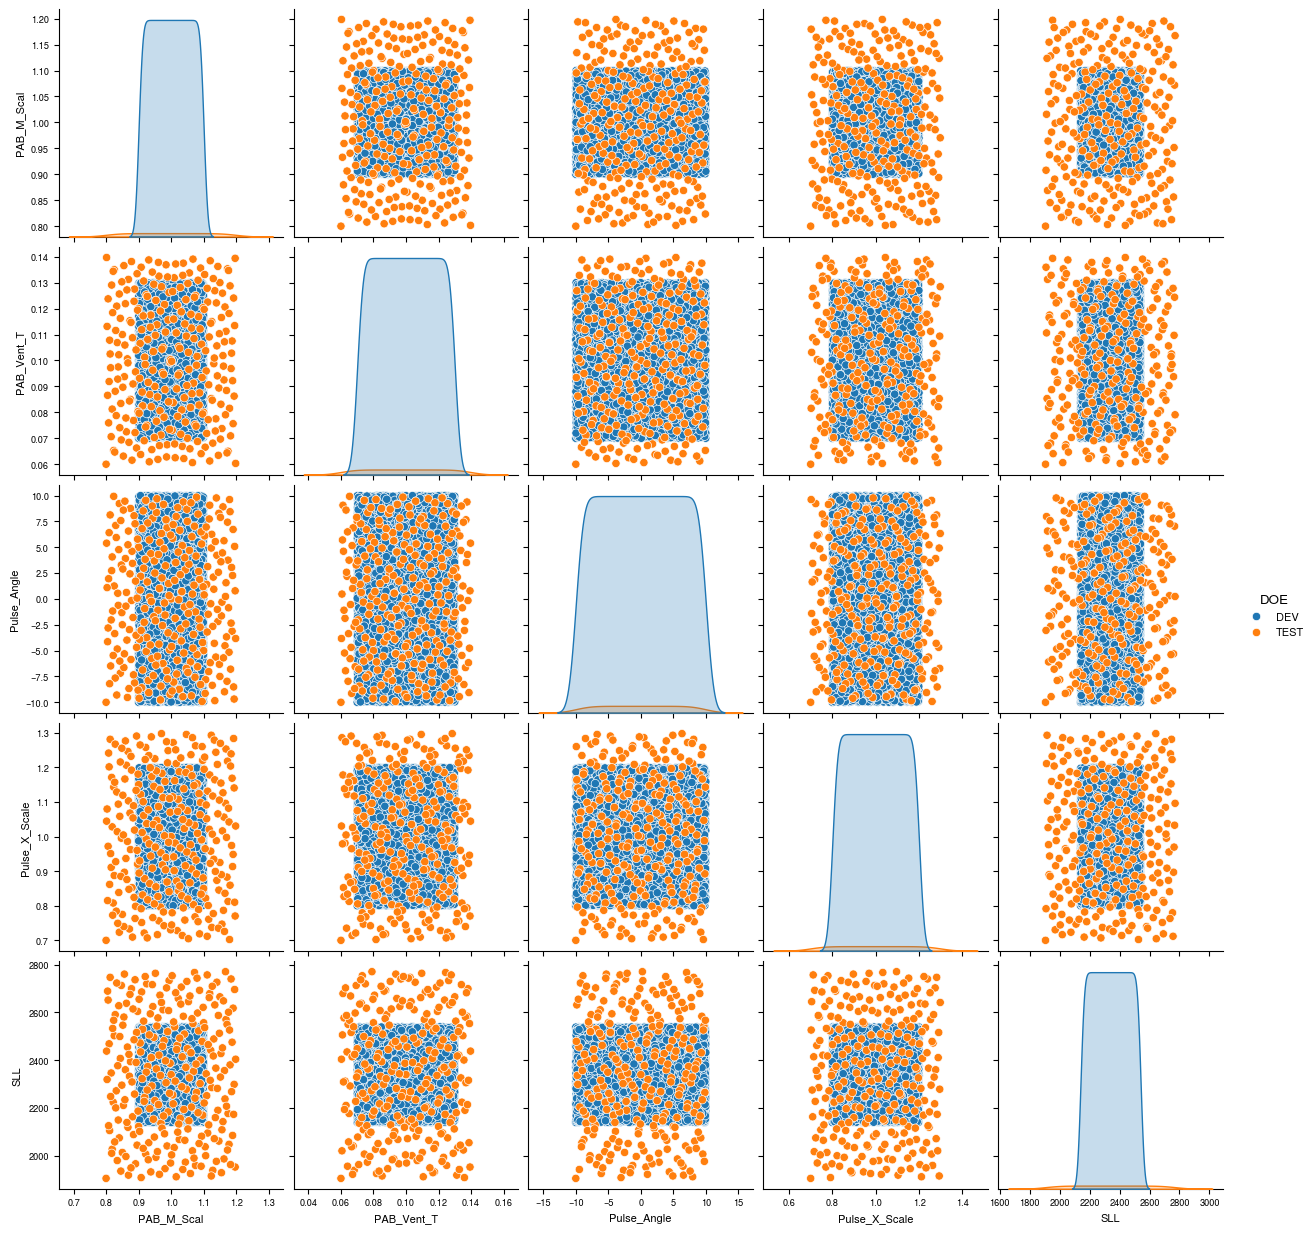

In [130]:
def plot_doe_heatmap(perc: int = 5):
    test_doe = (
        pl.scan_parquet(TEST_DOE_FPATH)
        .filter(pl.col(STR.perc) == perc)
        .select(pl.exclude([STR.perc, STR.id]))
        .with_columns(pl.lit("TEST").alias("DOE"))
    )
    dev_doe = (
        pl.scan_parquet(DEV_DOE_FPATH)
        .filter(pl.col(STR.perc) == perc)
        .select(pl.exclude([STR.perc, STR.sim_id]))
        .with_columns(pl.lit("DEV").alias("DOE"))
    )
    db = pl.concat([dev_doe, test_doe]).collect().to_pandas()

    sns.pairplot(db, hue="DOE")


plot_doe_heatmap()

In [83]:
def get_inter_extrapolation_ids(perc: int = 5, threshold: float = 0.03) -> List[int]:
    ranges = get_dev_set_para_ranges(DEV_DOE_FPATH, perc)
    test_doe = pl.scan_parquet(TEST_DOE_FPATH).filter(pl.col(STR.perc) == perc).collect().to_pandas().set_index(STR.id)

    ids = set(test_doe.index)
    for factor in ranges.columns:
        ids &= set(test_doe[test_doe[factor].between((1-threshold)*ranges.loc["MIN", factor], (1+threshold)*ranges.loc["MAX", factor])].index)

    return sorted(ids)


len(get_inter_extrapolation_ids())

70

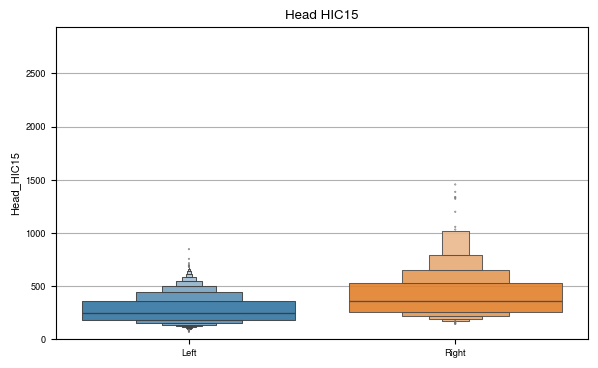

In [8]:
def single_boxplot(
    db_left_path: Path,
    db_right_path: Path,
    injury_criterion: str,
    perc: int,
    ax: Optional[matplotlib.axes.Axes] = None,
    name_left: str = "Left",
    name_right: str = "Right",
    ids_left: Optional[List[int]] = None,
    ids_right: Optional[List[int]] = None,
    title: str = "",
) -> None:
    # data
    db_left=get_inj_data(db_left_path, injury_criterion, perc=perc, ids=ids_left)
    db_right=get_inj_data(db_right_path, injury_criterion, perc=perc, ids=ids_right)

    if ax is None:
        _, ax = plt.subplots(figsize=(WIDTH, WIDTH / 1.618))

    sns.boxenplot(y=db_left, x=[name_left] * db_left.shape[0], ax=ax, flier_kws={"s": 0.2}, alpha=0.9)
    sns.boxenplot(y=db_right, x=[name_right] * db_right.shape[0], ax=ax, flier_kws={"s": 0.2}, alpha=0.9)

    # sns.rugplot(y=db_left.loc[outer_ids], ax=ax)
    # sns.rugplot(y=db_left.loc[inner_ids], ax=ax)
    ax.set_title(title)
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    # ax.set_xlim(-0.5, 1.5)

    r_min, r_max = 0, 0
    for p in (5, 50, 95):
        db_ = get_inj_data(db_right_path, injury_criterion, perc=p, ids=ids_right)
        r_min = min(r_min, db_.min())
        r_max = max(r_max, db_.max())
    ax.set_ylim([r_min, r_max])
    ax.locator_params(axis="y", nbins=8)


single_boxplot(
    db_left_path=DEV_INJ_FPATH,
    db_right_path=TEST_INJ_FPATH,
    perc=5,
    injury_criterion="Head_HIC15",
    title="Head HIC15",
)

2025-01-04 14:09:12,941     INFO  MainProcess  MainThread maxp pruned
2025-01-04 14:09:12,962     INFO  MainProcess  MainThread cmap pruned
2025-01-04 14:09:12,963     INFO  MainProcess  MainThread kern dropped
2025-01-04 14:09:12,965     INFO  MainProcess  MainThread post pruned
2025-01-04 14:09:12,966     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 14:09:12,972     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 14:09:12,981     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 14:09:13,000     INFO  MainProcess  MainThread glyf pruned
2025-01-04 14:09:13,002     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 14:09:13,004     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 14:09:13,006     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 7 glyphs before
2025-01-04 14:09:13,007     INFO  MainProcess  MainThread Glyph names: ['.notdef', '.null', 'five', 'nonmarkingreturn', 'one', 'space', 'three']
2025-01-04 14:09

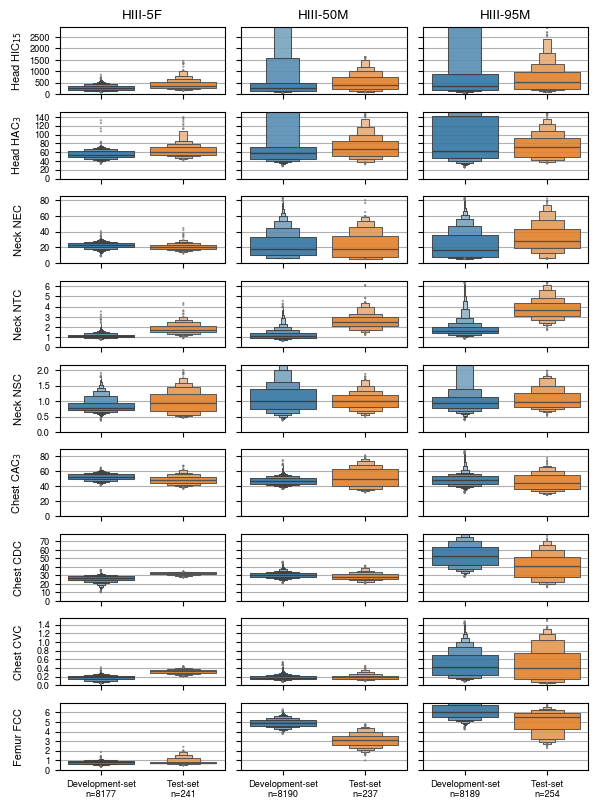

In [70]:
def full_plot(save: bool = False):
    fig, ax = plt.subplots(ncols=3, nrows=len(INJURIES), figsize=(WIDTH, 1.35 * WIDTH), sharex="col", sharey="row")

    for i, inj in enumerate(INJURIES):
        for j, perc in enumerate([5, 50, 95]):
            db_left = get_inj_data(DEV_INJ_FPATH, inj, perc=perc)
            db_right = get_inj_data(TEST_INJ_FPATH, inj, perc=perc)
            single_boxplot(
                db_left_path=DEV_INJ_FPATH,
                name_left=f"Development-set\nn={db_left.shape[0]}",
                db_right_path=TEST_INJ_FPATH,
                name_right=f"Test-set\nn={db_right.shape[0]}",
                perc=perc,
                injury_criterion=inj,
                ax=ax[i, j],
            )

            if i == 0:
                ax[i, j].set_title(f"HIII-{perc}{'F' if perc == 5 else 'M'}")
            if j == 0:
                ax[i, j].set_ylabel(INJ_NAMES[inj])

    
    fig.align_ylabels(ax)
    fig.set_figheight(1.35 * WIDTH)
    fig.set_figwidth(WIDTH)


    if save:
        save_fig(fig, "injury_criteria_comparison", close=False)


full_plot(save=True)

In [71]:
def get_same_lvl():
    alt_dev_doe = pd.read_parquet(ALT_DEV_DOE_FPATH).set_index(STR.perc, append=True)

    selector = pd.Series(True, index=alt_dev_doe.index)
    for factor in alt_dev_doe.columns:
        lvls = sorted(alt_dev_doe[factor].unique())
        selector &= alt_dev_doe[factor].isin([lvls[0], lvls[2], lvls[4]])

    alt_dev_doe = alt_dev_doe[selector].index

    parser = pd.read_parquet(ALT_DEV_PARSER_PATH).set_index(STR.perc, append=True)

    return sorted(set(parser.loc[alt_dev_doe, STR.id].values))


len(get_same_lvl())

243

2025-01-04 14:20:10,990     INFO  MainProcess  MainThread maxp pruned
2025-01-04 14:20:11,007     INFO  MainProcess  MainThread cmap pruned
2025-01-04 14:20:11,009     INFO  MainProcess  MainThread kern dropped
2025-01-04 14:20:11,010     INFO  MainProcess  MainThread post pruned
2025-01-04 14:20:11,011     INFO  MainProcess  MainThread FFTM dropped
2025-01-04 14:20:11,016     INFO  MainProcess  MainThread GPOS pruned
2025-01-04 14:20:11,022     INFO  MainProcess  MainThread GSUB pruned
2025-01-04 14:20:11,034     INFO  MainProcess  MainThread glyf pruned
2025-01-04 14:20:11,036     INFO  MainProcess  MainThread Added gid0 to subset
2025-01-04 14:20:11,037     INFO  MainProcess  MainThread Added first four glyphs to subset
2025-01-04 14:20:11,039     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 7 glyphs before
2025-01-04 14:20:11,040     INFO  MainProcess  MainThread Glyph names: ['.notdef', '.null', 'five', 'nonmarkingreturn', 'one', 'space', 'three']
2025-01-04 14:20

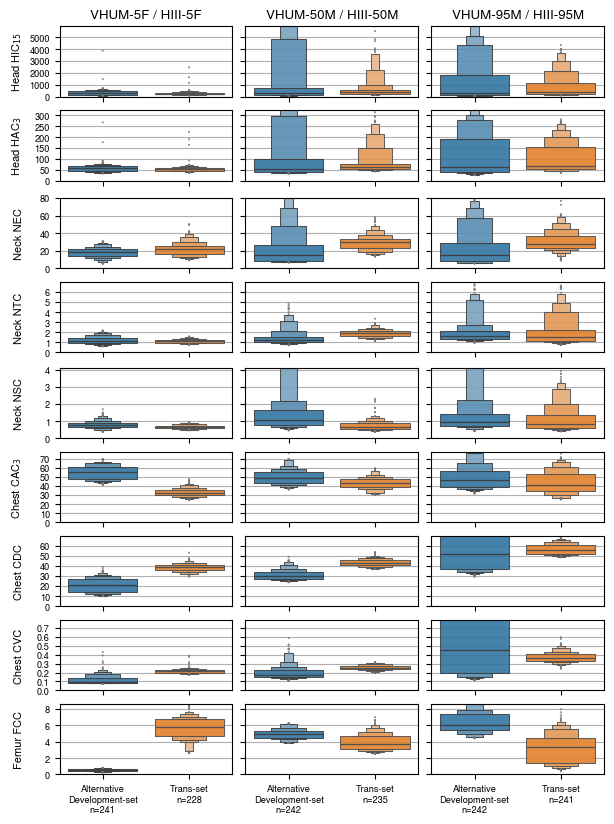

In [78]:
def full_plot_2(save: bool = False):
    fig, ax = plt.subplots(ncols=3, nrows=len(INJURIES), sharex="col", sharey="row", layout="constrained")
    alt_dev_set_ids = get_same_lvl()

    for i, inj in enumerate(INJURIES):
        for j, perc in enumerate([5, 50, 95]):
            db_left = get_inj_data(ALT_DEV_INJ_FPATH, inj, perc=perc, ids=alt_dev_set_ids)
            db_right = get_inj_data(TRANS_INJ_FPATH, inj, perc=perc)
            single_boxplot(
                db_left_path=ALT_DEV_INJ_FPATH,
                name_left=f"Alternative\nDevelopment-set\nn={db_left.shape[0]}",
                ids_left=alt_dev_set_ids,
                db_right_path=TRANS_INJ_FPATH,
                name_right=f"Trans-set\nn={db_right.shape[0]}",
                injury_criterion=inj,
                perc=perc,
                ax=ax[i, j],
            )

            if i == 0:
                ax[i, j].set_title(f"VHUM-{perc}{'F' if perc == 5 else 'M'} / HIII-{perc}{'F' if perc == 5 else 'M'}")
            if j == 0:
                ax[i, j].set_ylabel(INJ_NAMES[inj])

    fig.align_ylabels(ax)
    fig.set_figheight(1.35 * WIDTH)
    fig.set_figwidth(WIDTH)
    if save:
        save_fig(fig, "injury_criteria_comparison_virthuman", close=False)


full_plot_2(save=True)

243